# Computing the Grad-CAM on a pretrained model

In this notebook we will first pretrain a model without Grad-CAM, then show how to compute the Grad-CAM on it.

## Setup

First we will install required packages and import them,

In [1]:
%pip install -U numpy flax optax jaxopt datasets einops scikit-learn tqdm

import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import jaxopt
import datasets
import einops
from sklearn import metrics
from tqdm.auto import trange
import fgradcam

Next, we define our loss function,

In [2]:
def ce_loss(model):
    "A simple cross-entropy loss function"
    @jax.jit
    def _loss(params, X, Y):
        logits = jnp.clip(model.apply(params, X), 1e-15, 1 - 1e-15)
        one_hot = jax.nn.one_hot(Y, logits.shape[-1])
        return -jnp.mean(jnp.einsum("bl,bl -> b", one_hot, jnp.log(logits)))
    return _loss

Then an accuracy function to see how well our model went,

In [3]:
def accuracy(model, variables, X, Y, batch_size=1000):
    """
    Calculate the accuracy of the model across the given dataset

    Arguments:
    - model: Model function that performs predictions given parameters and samples
    - variables: Parameters and other learned values used by the model
    - X: The samples
    - Y: The corresponding labels for the samples
    - batch_size: Amount of samples to compute the accuracy on at a time
    """
    @jax.jit
    def _apply(batch_X):
        return jnp.argmax(model.apply(variables, batch_X), axis=-1)
    preds, Ys = [], []
    for i in range(0, len(Y), batch_size):
        i_end = min(i + batch_size, len(Y))
        preds.append(_apply(X[i:i_end]))
        Ys.append(Y[i:i_end])
    return metrics.accuracy_score(jnp.concatenate(Ys), jnp.concatenate(preds))

And a model loading function, we will load the Fashion MNIST dataset,

In [4]:
def load_mnist():
    """
    Load the Fashion MNIST dataset http://arxiv.org/abs/1708.07747

    Arguments:
    - seed: seed value for the rng used in the dataset
    """
    ds = datasets.load_dataset("fashion_mnist")
    ds = ds.map(
        lambda e: {
            'X': einops.rearrange(np.array(e['image'], dtype=np.float32) / 255, "h (w c) -> h w c", c=1),
            'Y': e['label']
        },
        remove_columns=['image', 'label']
    )
    features = ds['train'].features
    features['X'] = datasets.Array3D(shape=(28, 28, 1), dtype='float32')
    ds['train'] = ds['train'].cast(features)
    ds['test'] = ds['test'].cast(features)
    ds.set_format('numpy')
    return ds

Finally, we define our model to train,

In [5]:
class CNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=48, kernel_size=(3, 3), padding="SAME")(x)
        x = nn.relu(x)
        x = nn.Conv(features=32, kernel_size=(3, 3), padding="SAME")(x)
        x = nn.relu(x)
        x = nn.Conv(features=16, kernel_size=(3, 3), padding="SAME")(x)
        x = nn.relu(x)
        x = einops.rearrange(x, "b h w c -> b (h w c)")
        x = nn.Dense(10)(x)
        x = nn.softmax(x)
        return x

## Pretraining

We will now perform pretraining of the model,

In [6]:
# Setup the dataset and model
dataset = load_mnist()
X, Y = dataset['train']['X'], dataset['train']['Y']
model = CNN()
params = model.init(jax.random.PRNGKey(42), X[:1])

# Train the model
solver = jaxopt.OptaxSolver(ce_loss(model), optax.sgd(0.1), maxiter=3000)
state = solver.init_state(params)
step = jax.jit(solver.update)
rng = np.random.default_rng()
for i in (pbar := trange(solver.maxiter)):
    idx = rng.choice(len(Y), size=128, replace=False)
    params, state = step(params=params, state=state, X=X[idx], Y=Y[idx])
    pbar.set_postfix_str(f"LOSS: {state.value:.3f}")
final_acc = accuracy(model, params, dataset['test']['X'], dataset['test']['Y'])
print(f"Final accuracy: {final_acc:.3%}")

Found cached dataset fashion_mnist (/home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1/cache-b8e7275af83c3fa9.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1/cache-8828d85b351285eb.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1/cache-bdfe3f62ee86c32f.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1/cache-2d99eaa895e32b89.arrow
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


  0%|          | 0/3000 [00:00<?, ?it/s]

Final accuracy: 89.750%


## Computing the Grad-CAM

To compute the Grad-CAM of the pretrained model, we must first correct a couple of things for setup, the model definition and the model parameters.

For the model definition, we must add a call of `fgradcam.observe` after the layer we want ot visualize with Grad-CAM,

In [7]:
class CNN2(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=48, kernel_size=(3, 3), padding="SAME")(x)
        x = nn.relu(x)
        x = nn.Conv(features=32, kernel_size=(3, 3), padding="SAME")(x)
        x = nn.relu(x)
        x = nn.Conv(features=16, kernel_size=(3, 3), padding="SAME")(x)
        x = nn.relu(x)
        x = fgradcam.observe(self, x)  # We add only this line for the visualization
        x = einops.rearrange(x, "b h w c -> b (h w c)")
        x = nn.Dense(10)(x)
        x = nn.softmax(x)
        return x

Next, we setup the model and the parameters, we create blank parameters and transfer the pretrained parameters into the correct place in the PyTree,

In [8]:
model2 = CNN2()
variables = model2.init(jax.random.PRNGKey(0), X[:1])
variables = {'params': params['params'], 'perturbations': variables['perturbations']}

And finally, with our setup done, we can compute and visualize our Grad-CAMs

Computing Grad-CAM heatmap...
Done. Plotting the results...


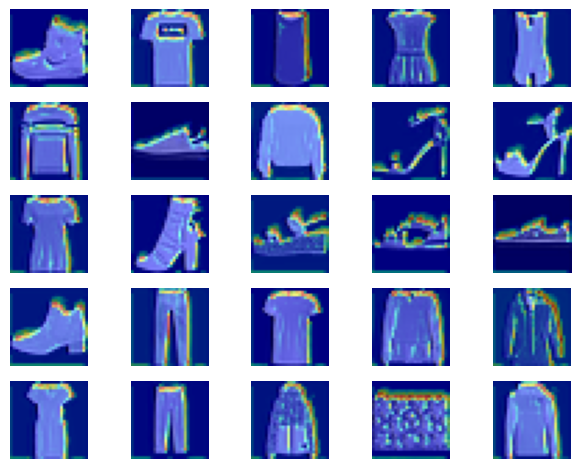

In [9]:
batch_size = 25
print("Computing Grad-CAM heatmap...")
heatmap = fgradcam.compute(model2, variables, X[:batch_size])
print("Done. Plotting the results...")
fig, axes = plt.subplots(nrows=round(batch_size**0.5), ncols=round(batch_size**0.5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    fgradcam.plot(X[i], heatmap[i], ax=ax)
plt.tight_layout()
plt.show()